In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
warnings.simplefilter("ignore")

import librosa
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

from sklearn.metrics import classification_report, confusion_matrix

In [123]:
df = pd.read_parquet("../data/processed/audio_features.parquet")

## Feature Engineering

In [125]:
path = df['filename'].iloc[0]
data, sample_rate = librosa.load(path)

In [126]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.85):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def apply_pitch_shift(data, sample_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

In [127]:
def extract_features(data):
    # MFCC
    mfcc = librosa.feature.mfcc(y=data, sr=sample_rate)
    result = mfcc
    return result

# funtion to transform audio
def transform_audio(data, fns):
    fn = random.choice(fns)
    if fn == apply_pitch_shift:
        fn_data = fn(data, sampling_rate)
    elif fn == "None":
        fn_data = data
    elif fn in [noise, stretch]:
        fn_data = fn(data)
    else:
        fn_data = data
    return fn_data


def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)


    #randomly transforming audio data
    fns = [noise, apply_pitch_shift, "None"]

    fn1_data = transform_audio(data, fns)
    fn2_data = transform_audio(fn1_data, fns)
    res1 = extract_features(fn2_data)
    result = [np.array(res1[:,:108])]

    fn1_data = transform_audio(data, fns)
    fn2_data = transform_audio(fn1_data, fns)
    res2 = extract_features(fn2_data)[:,:108]
    result.append(res2)

    fn1_data = transform_audio(data, fns)
    fn2_data = transform_audio(fn1_data, fns)
    res3 = extract_features(fn2_data)[:,:108]
    result.append(res3)

    return result

In [ ]:
X, Y = [], []
for path, emotion in zip(list(df['filename']), list(df['emotion'])):
    feature = get_features(path)
    for ele in feature:
        if ele.shape == (20, 108):
            X.append(ele)
            Y.append(emotion)

In [133]:
dfm = pd.DataFrame()
xx = pd.Series(X)
for i in range(20):
    dfm[i] = [k[i] for k in xx]

In [134]:
Features = dfm.copy()
Features['labels'] = Y
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,"[-782.3367, -772.8877, -749.4916, -708.55566, ...","[13.91177, 10.961353, -21.519993, -61.897984, ...","[12.279222, 22.54943, 40.53662, 49.383606, 46....","[10.11124, 6.2642164, -1.6117904, 3.688239, 6....","[7.9998703, 11.7753315, 11.626672, 8.248017, 1...","[6.411319, 2.4727736, 6.664854, 8.85792, 10.35...","[5.52915, 4.821377, 4.8849115, 7.1581097, 4.96...","[5.232438, 3.2913294, 6.704021, 8.278468, 7.78...","[5.2063775, 4.6718245, 6.724617, 8.548503, 9.0...","[5.121585, 6.6134586, 12.504795, 11.684286, 9....",...,"[4.2354603, 8.798123, 13.390255, 19.428118, 20...","[3.628673, 7.8074646, 11.580785, 7.69829, 5.07...","[3.1770384, 9.196668, 6.634467, -1.8408215, -5...","[2.9901333, 6.6212454, 10.257727, 14.660955, 1...","[3.0190191, 8.657054, 9.259325, 11.518011, 13....","[3.0860763, 4.894247, -0.4061783, -3.992463, -...","[2.9834533, 6.7356825, 13.47933, 15.965122, 18...","[2.5817876, 3.1042588, -2.807207, 0.7524681, -...","[1.8909223, 3.2068818, 7.162657, 4.748251, 1.0...",surprised
1,"[-503.17169467055317, -465.21156688045653, -47...","[-9.136052220992987, -1.3647464119345472, 1.48...","[-2.1739566925056053, -1.7861780505542593, -0....","[0.35347049479117054, 2.310857546213634, 0.013...","[-4.20964252745402, -3.516678512142744, -2.776...","[0.9808386208685441, 5.216006362109246, 5.6974...","[3.46012406536134, 6.017228174735319, 3.449710...","[5.33479752539505, 5.5589416687873525, 4.31125...","[-3.074502449289264, -1.447663929412352, 2.092...","[-4.866889145332835, -1.141857593096089, 0.374...",...,"[2.922248465966759, 5.576704800170502, 4.20687...","[-0.3234915916676848, 0.913412318008026, -3.14...","[7.781672261676165, 2.67466092991844, -0.30559...","[4.5115258429726754, 0.0646836764196313, -1.26...","[1.7502429883749664, 2.17296473540439, 3.44621...","[-1.2280572628776267, 3.578431592192112, 3.484...","[9.11160653871457, 8.78579864464027, 4.2493467...","[-1.817402023328321, -3.0707941635860925, -1.4...","[-2.9517866504802956, -3.430127037010001, 0.02...",surprised
2,"[-404.8118763525794, -363.55851698276217, -375...","[-5.115817850180672, 2.1452773015475435, 3.684...","[-4.868646495401062, -5.057389020990788, -5.15...","[3.723162823478912, 3.8559601937378356, 2.6635...","[-0.9169255687088826, 1.345066762115269, 0.641...","[2.995023072793219, 5.074558240484862, 4.09718...","[-0.46253362414747534, -1.5816587556493444, -3...","[6.21360325960744, -0.23893257930061268, -3.35...","[-0.4125131239791391, -2.2942036808590465, -2....","[-2.163773600281628, -4.608820545964717, -0.63...",...,"[-0.6055931062594782, 3.307428953660441, 2.463...","[0.10784057395845625, 1.559834513040463, -0.56...","[3.2551021692594277, 6.008045125775164, 3.1251...","[0.17867572374647378, 1.878819506246313, -0.67...","[1.2282200768168814, 2.4591783271141416, 0.244...","[-0.5310001990795015, -3.255110572354109, -5.7...","[-1.610048874793141, -2.8191609994897755, -3.7...","[-5.840615002910647, -4.63228264411586, -1.374...","[1.2517757394537543, 3.837918175162708, 6.5308...",surprised
3,"[-392.7907801826956, -358.2517171903305, -358....","[-0.026612916463395895, 0.017243124604067794, ...","[5.293595693764397, 2.651705380619768, -0.1845...","[-1.3600496597138938, 0.5902181041942435, -3.9...","[-3.529420056242028, -0.5758358878111882, 1.25...","[-1.8083782325524194, -0.738118666109976, 0.19...","[0.20363345084400403, 0.4339491351534522, -3.3...","[-3.559731450481569, -0.1562322824256563, 0.27...","[-4.802756335347523, 0.017621880321515904, 1.3...","[0.04399321925945676, -1.6897836185703041, -3....",...,"[4.063895350051569, 4.022710516562099, 2.49578...","[-0.033261696602146396, 0.2465190297142963, 0....","[2.5527144750358115, -0.286866530346261, 1.937...","[4.312351457813975, -3.794174452901906, -2.139...","[2.9407231851060125, -0.61134778282609, 1.2904...","[-1.707866638161781, -1.8461248272987079, 1.92...","[0.5568707878406337, -0.3508582496008108, 3.02...","[8.384451309233864, 5.694752216674363,

In [135]:
X = np.array(X)
Y = np.array(Y)
X.shape, Y.shape

((4275, 20, 108), (4275,))

## Encoding

In [136]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

## Train Test Split

In [137]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=21, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3420, 20, 108), (3420, 8), (855, 20, 108), (855, 8))

In [138]:
x_train = np.expand_dims(x_train, axis=3)
x_train = np.swapaxes(x_train, 1, 2)
x_train = np.expand_dims(x_train, axis=3)

x_test = np.expand_dims(x_test, axis=3)
x_test = np.swapaxes(x_test, 1, 2)
x_test = np.expand_dims(x_test, axis=3)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3420, 108, 20, 1, 1), (3420, 8), (855, 108, 20, 1, 1), (855, 8))

In [139]:
input_shape = x_train.shape[1:]
input_shape

(108, 20, 1, 1)

In [140]:
x_train = x_train.reshape((-1, 108, 20, 1))
x_test = x_test.reshape((-1, 108, 20, 1))

## Modelling

In [144]:
model=Sequential()

model.add(TimeDistributed(Conv1D(16, 3, padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Flatten()))

model.add(LSTM(32))
model.add(Dropout(0.2))

model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=8, activation='softmax'))

model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_42             │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_43             │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_44             │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [145]:
model.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience=4, min_lr=0.0000001)

epochs = 100
history = model.fit(x_train, y_train, batch_size=64, epochs=epochs, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 44s 201ms/step - accuracy: 0.1608 - loss: 2.0924 - val_accuracy: 0.2421 - val_loss: 2.0016 - learning_rate: 0.0010
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.2204 - loss: 1.9721 - val_accuracy: 0.2936 - val_loss: 1.8968 - learning_rate: 0.0010
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.2647 - loss: 1.8678 - val_accuracy: 0.3205 - val_loss: 1.7144 - learning_rate: 0.0010
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.3264 - loss: 1.7206 - val_accuracy: 0.3696 - val_loss: 1.6219 - learning_rate: 0.0010
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.3611 - loss: 1.6491 - val_accuracy: 0.4140 - val_loss: 1.5446 - learning_rate: 0.0010
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.4098 - loss: 1.5521 - val_accuracy: 0.4608 - val_loss: 1.4778 - learning_rate: 0.0010
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.4505 - loss: 1.4709 

## Evaludation

In [146]:
y_pred = model.predict(x_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step


In [149]:
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

In [153]:
print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

           0       0.78      0.83      0.81       109
           1       0.84      0.79      0.81       118
           2       0.67      0.79      0.73       107
           3       0.66      0.65      0.65       109
           4       0.82      0.64      0.72       128
           5       0.60      0.75      0.67        57
           6       0.64      0.63      0.63       103
           7       0.76      0.73      0.75       124

    accuracy                           0.73       855
   macro avg       0.72      0.73      0.72       855
weighted avg       0.73      0.73      0.73       855



In [169]:
cm = confusion_matrix(y_test_labels, y_pred_labels)

<Axes: >

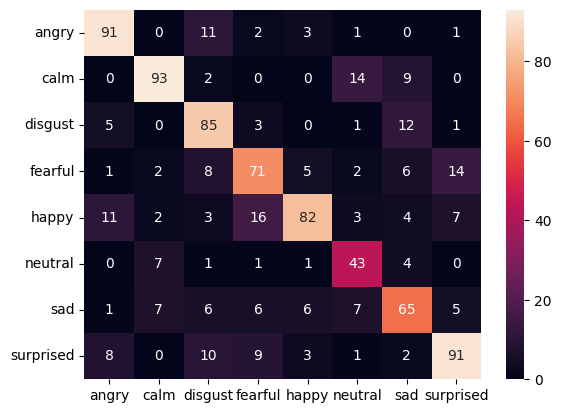

In [172]:
labels = encoder.categories_[0]

sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)